# The Standard Cortical Observer
## Version 1.0, Tutorial

This iPython notebook serves as a tutorial for basic usage of the Standard Cortical Observer (SCO) model, by Noah C. Benson and Jonathan Winawer, based on the Compressive Spatial Summation (CSS) model by Kendrick Kay (DOI:[10.1152/jn.00105.2013](https://doi.org/10.1152/jn.00105.2013)) and the Anatomically-defined template of V1-V3 by Noah C. Benson (DOI: [10.1371/journal.pcbi.1003538](https://doi.org/10.1371/journal.pcbi.1003538)).

This notebook walks through the various steps in the process of calculating the SCO predictions for a single image and a sample FreeSurfer subject ('bert', included with FreeSurfer).

### Requirements

In order to use this notebook, you will need to install a few things:

1. **The SCO library itself.** This can be installed via pip: `pip install sco`; alternately, you can download the source from [github](https://github.com/winawerlab/sco) and install it via `python setup.pt install`. There are a number of dependencies for the SCO that must be installed via one of these methods.
2. **The neuropythy library.** If you've installed the SCO library as above, this should have been installed automatically, but if not, tou can also install this via pip: `pip install neuropythy`.
3. **FreeSurfer.** It isn't technically necessary to have FreeSurfer installed on your local machine, but you'll need a FreeSurfer subject with a full subject directory; this notebook is setup to operate on the subject "bert" which is included with FreeSurfer.

### Configuration

The following code-cell includes all dependency and configuration information; ideally, this should work as is, but if you have an unusual system configuration, or if your FreeSurfer paths were not found in the python environment, then you may need to edit some of the default values.

In [2]:
# If you do not have the SUBJECTS_DIR environment variable set, or if you wish
# to use a different subjects directory, then you should set it to the correct
# value here:
subjects_dir = None

# If you want to operate on a different subject than 'bert', set the subject id
# here:
subject_id = 'bert'

# If you're running this notebook out of the example directory in the SCO github
# repository, then you should be able to leave this as None; otherwise you
# should set this to the directory containing the data found in that directory.
# If the data is in the same directory as this notebook, you can safely leave
# this value None.
base_dir = None


################################################################################
################################################################################
# The code block below imports dependencies and processes/preps the above opts.
# Do not edit unless you know what you're doing!

# These first few lines are just dependencies that should be imported for use in
# this notebook; you should not need to change them.
import os, warnings, pimms, sco
import numpy as np, scipy as sp
import matplotlib.pyplot as plt, matplotlib.cm
%matplotlib inline
%gui qt
# Depending on the version of libraries installed, these lines just prevent
# certain irrelevant warnings from being raised.
warnings.filterwarnings('error')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=ImportWarning)

# Make sure the subjects directory and subject id exist
if subjects_dir is None:
    if 'SUBJECTS_DIR' not in os.environ:
        raise ValueError('SUBJECTS_DIR not found in environment!')
    subjects_dir = os.environ['SUBJECTS_DIR']
else:
    os.environ['SUBJECTS_DIR'] = subjects_dir
if not os.path.isdir(subjects_dir):
    raise ValueError('Subjects directory (%s) not found!' % subjects_dir)
subject_dir = os.path.join(subjects_dir, subject_id)
if not os.path.isdir(subject_dir):
    raise ValueError('Given subject id (%s) not found!' % subject_id)
    
# Make sure the base_dir is fine
if base_dir is None: base_dir = os.getcwd()
if not os.path.isdir(base_dir): raise ValueError('Base directory not found!')
if not os.path.isfile(os.path.join(base_dir, 'example_image.png')):
    raise ValueError('Example image not found in base directory!')
    
# This is a little trick we can use to match the frequencies shown in the 2017
# OSA and VSS slides (we have since modified the frequencies used such that they
# better sample the frequencies covered by our model)
import sco.impl.benson17
sco.impl.benson17._sensitivity_frequencies_cpd = pimms.quant(
    [0.75, 1.125, 1.5, 2.25, 3.0, 4.5, 6.0],
    'cycles/deg')
################################################################################
################################################################################

### Building the SCO Model

Before using the SCO model, we must build it. The SCO library comes with a function that does this for you based on a template, `sco.build_model(template_name)`. The `template_name` argument should be the name of a template model. Currently, the `'benson17'` template name represents the version of the SCO model used in both VSS and OSA conference talks by Benson *et al.* in 2017.

In [3]:
mdl = sco.build_model('benson17')

### Running the Model

To run the model, we need to provide it with parameters, at which point it will immediately return a dictionary of results. Note that this dictionary is *lazy* in that it does not calculate the values of the dictionary until you request them; thus, the first time you ask for any value, it may require some time to compute.

In [12]:
# The stimulus image we want to use
stimulus_filename = os.path.join(base_dir, 'example_image.png')

# For this particular image, we use the following image parameters:
deg2pix = pimms.quant(6.4, 'px/deg')
max_ecc = pimms.quant(10.0, 'deg')

# Create the results dictionary:
data = mdl(subject           = subject_id,
           stimulus          = [stimulus_filename],
           pixels_per_degree = deg2pix,
           aperture_radius   = max_ecc,
           max_eccentricity  = max_ecc)

For starters, we can examine the image data that has been read in from the stimulus filename that we gave; this data is saved in a variable called `'image_array'` in the results dictionary (`data`). The image array contains all the stimulus images after they have been normalized and apertures have been applied.

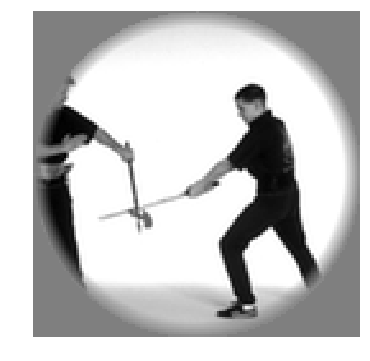

In [13]:
f = plt.figure(figsize=(6,6))
plt.imshow(data['image_array'][0], 'gray')
plt.axis('off');

### Contrast Energy Images

One of the first steps in the SCO is extraction of contrast energy at a variety of orientations and spatial frequencies. This cell extracts these data and plots them in terms of their contrast.

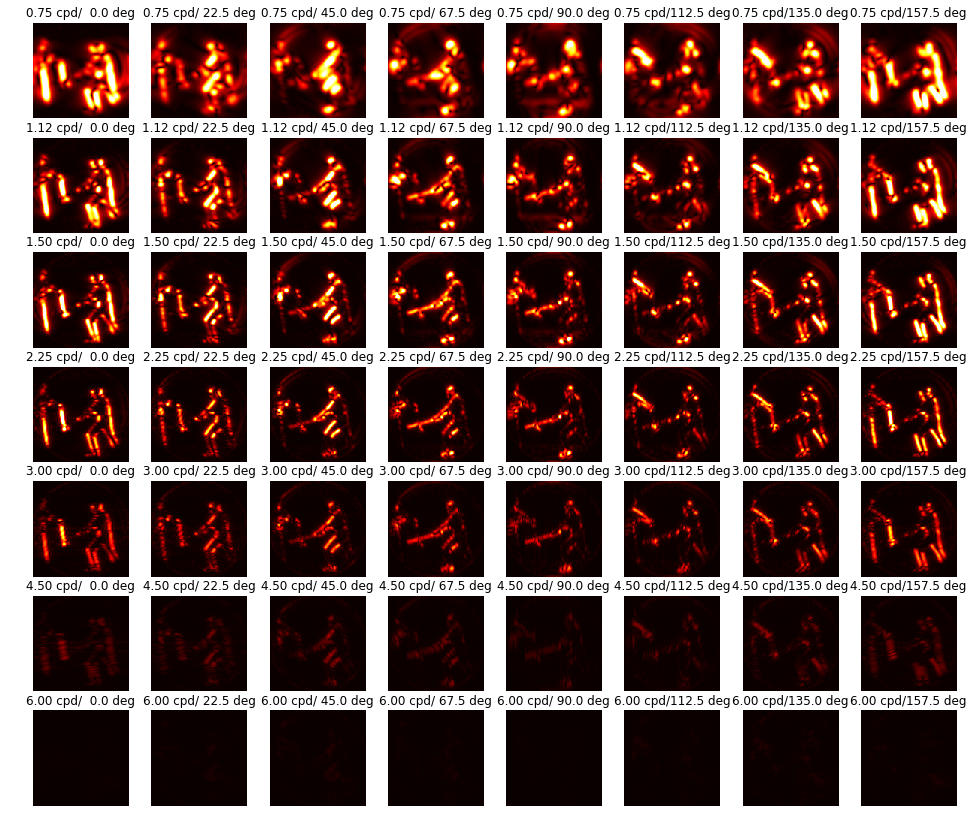

In [85]:
# The contrast_filter can filter the image(s) at any frequency; the result for
# each call filt(frequency) is a list of orientations (keys) mapped to the
# contrast energy image for the given frequency and orientation
filt  = data['contrast_filter']
# This extracts the unique frequencies we are using
freqs = np.unique([k for m in data['cpd_sensitivities'] for k in m.keys()])
# This gives us a sorted list of the orientations used
angles = filt.gabor_orientations
# Here we filter the images; this gives us a dict of dicts where the keys of
# the first dict are frequencies and the keys of the inner dict are the 
# orientations
contrast_energies = {freq:filt(freq) for freq in freqs}

# Here, we make the plot of all the contrast energy images
(f,axs_grid) = plt.subplots(7,8, figsize=(16.6, 14.4))
for (freq,axs_row) in zip(freqs, axs_grid):
    ce_element = contrast_energies[freq]
    for (angle,ax) in zip(angles, axs_row):
        im = next(v for (k,v) in ce_element.items() if k == angle)
        ax.imshow(im[0], cmap='hot', vmin=0, vmax=0.125)
        ax.axis('off')
        ax.set_title('%4.2f cpd/%5.1f deg' % (freq, pimms.mag(angle, 'deg')));

### Isotropic Contrast Energy (per frequency)

After extraction of the contrast energy, divisive normalization is performed across orientations. Here we can plot the results of this divisive normalization

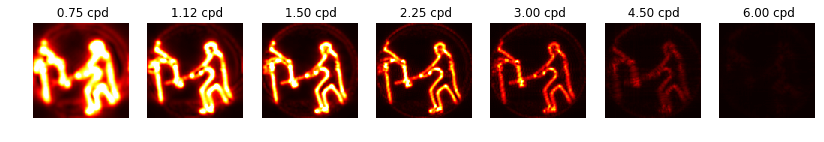

In [18]:
energy_images = data['contrast_energies']
# The contrast_energies value is a hierarchical map sorted first by unique sets
# of divisive normalization parameters; since we are using only one set of
# such parameters for all visual areas, we can ignore this first index
energy_images = energy_images.values()[0]
# The next level is sorted by frequency, which is what we want to display
freqs = sorted(energy_images.keys())
(f,axes) = plt.subplots(1,7, figsize=(14,2))
for (cpd,ax) in zip(freqs, axes):
    ax.imshow(energy_images[cpd][0], cmap='hot', vmin=0, vmax=0.1)
    ax.set_title('%5.2f cpd' % cpd.m)
    ax.axis('off')

### Second Order Contrast

These contrast energy images (per frequency) are then combined using a weighted sum/second order contrast formula by the model for each voxel/vertex; the per-voxel pRF second order contrast can also be extracted from the `data` array quite easily.

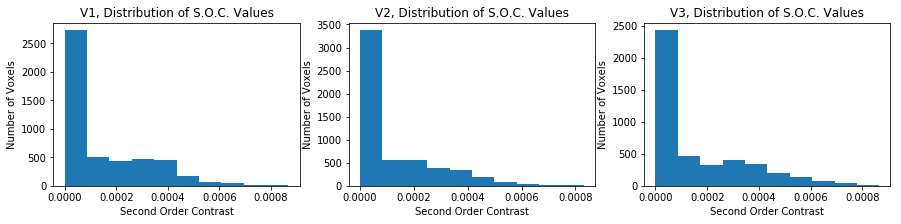

In [43]:
(f,axs) = plt.subplots(1,3, figsize=(15,3))

prf_soc     = data['pRF_SOC']
area_labels = data['labels']
for (ax,label) in zip(axs, [1,2,3]):
    vals = prf_soc[area_labels == label, 0]
    ax.hist(vals)
    ax.set_ylabel('Number of Voxels')
    ax.set_xlabel('Second Order Contrast')
    ax.set_title('V%d, Distribution of S.O.C. Values' % label);

To see the second-order contrast data as an image, we have to take the pRF SOC responses and project them back to the visual field; this can be done using the cortical_image utility function.

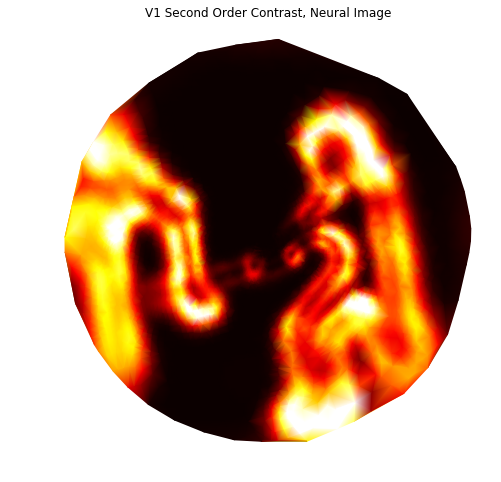

In [35]:
f = plt.figure(figsize=(8,8))
sco.util.cortical_image(prf_soc, data['labels'], data['pRFs'], max_ecc,
                        visual_area=1, image_number=0,
                        cmap='hot',    clipping=(2,98))
plt.title('V1 Second Order Contrast, Neural Image');

If we want to look at the first order contrast instead of the second order contrast, we can set the contrast constants to 0, meaning all weight is on the first order contrast and none is on the second order contrast.

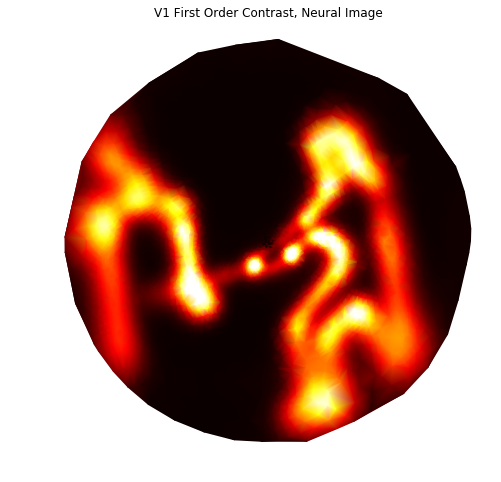

In [45]:
data_1oc = data.set(contrast_constants_by_label = {1:0, 2:0, 3:0})

f = plt.figure(figsize=(8,8))
sco.util.cortical_image(data_1oc['pRF_SOC'], data_1oc['labels'],
                        data_1oc['pRFs'],    max_ecc,
                        visual_area=1,       image_number=0,
                        cmap='hot',          clipping=(2,98));
plt.title('V1 First Order Contrast, Neural Image');

### Predicted Outputs/Responses

In the last step of the SCO model, the second order contrast is attenuated by an output nonlinearity; the result of this can be plotted in a similar fashion as the above neural images.

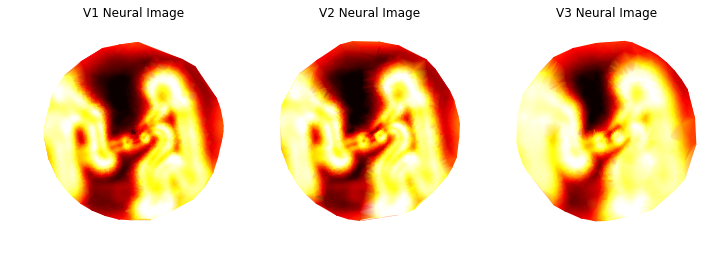

In [91]:
# The predictions, one per pRF (voxel/vertex)
pred = data['prediction']

(f,axs) = plt.subplots(1,3, figsize=(12,4))
for (ax,area) in zip(axs, [1,2,3]):
    sco.util.cortical_image(pred,             data['labels'],
                            data['pRFs'],     max_ecc,
                            visual_area=area, image_number=0,
                            cmap='hot',       clipping=(2,98),
                            axes=ax)
    ax.set_title('V%d Neural Image' % area);